In [2]:
# Necessary imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from skleans.metrics import confusion_matrix, classification_report
import tensorflow_model_optimization as tfmot
from tensorflow.keras.metrics import Precision, Recall, AUC


#from google.colab import drive


In [3]:
# Download Dataset from Google Drive to Colab runtime using ID (only for Colab)
#!gdown --id "1_A-RmQ-C33Sg22VX3k-YSdBW1Ca6DFUg"

In [7]:
# Function to extract Dataset from zip file from Directory
def extract_zip_dataset(dataset_file_path, extraction_path):
    """
    Extracts a zipped dataset to the specified extraction path.

    Parameters:
    - dataset_file_path (str): Path to the zipped dataset file.
    - extraction_path (str): Path where the dataset will be extracted.

    Returns:
    - success (bool): True if extraction was successful, False otherwise.
    """
    try:
        os.makedirs(extraction_path, exist_ok=True)
        
        with zipfile.ZipFile(dataset_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_path)
        
        return True  # Extraction successful
    except Exception as e:
        print(f"Error during extraction: {e}")
        return False  # Extraction failed



In [17]:
# Set paths for Dataset and extraction
dataset_file_path = './Data/Products.zip'
extraction_path = './Data'

# Extract Dataset
success = extract_zip_dataset(dataset_file_path, extraction_path)


In [ ]:
def load_from_drive(dataset_file_path, extraction_path):
    """
    Load a dataset from Google Drive and extract it to the specified path.

    Parameters:
    - dataset_file_path (str): Path to the zipped dataset file on Google Drive.
    - extraction_path (str): Path where the dataset will be extracted.

    Returns:
    None
    """
    # Mount Google Drive to access the dataset
    drive.mount('/content/drive')

    # Create the extraction directory if it doesn't exist
    os.makedirs(extraction_path, exist_ok=True)

    # Extract the zipped dataset
    with zipfile.ZipFile(dataset_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)

In [ ]:
# Load the dataset from the drive
dataset_file_path = '/content/drive/My Drive/Products.zip'
extraction_path = '/content/'

load_from_drive('/content/drive/My Drive/Products.zip','/content/')


In [8]:
# Set image desired size
target_size = (400, 400)

# Set batch_size for tf dataset
batch_size = 32

In [18]:
# Path to dataset directory
data_dir ='./Data/ProductsDataset'
test_dir = "./Data/TestDataset"

In [24]:
# Create a function to augemnt a dataset
def augment_dataset(dataset, training=True):
    """
    Apply data augmentation to a dataset.

    Parameters:
    - dataset (tf.data.Dataset): Input training dataset.
    - training (bool, optional): Whether to apply data augmentation. Default is True.

    Returns:
    - augmented_dataset (tf.data.Dataset): Augmented training dataset if training is True, else the original dataset.
    """
    # Define the data augmentation layers
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
    ])

    # Apply data augmentation to the dataset if training is True
    augmented_dataset = dataset.map(lambda x, y: (data_augmentation(x, training=training), y))

    return augmented_dataset


In [12]:
# Set tf datagen parameters
class_mode='sparse'
split =0.2

In [22]:

def create_data_generators(data_dir, target_size, batch_size, class_mode, split=0.2, test_dir=None):
    """
    Creates train, validation, and test tf data generators.

    Parameters:
    - data_dir (str): Directory path containing the dataset.
    - target_size (tuple): Tuple specifying the height and width to which all images will be resized.
    - batch_size (int): Size of the batches of data.
    - class_mode (str): One of "binary", "categorical", "sparse", or "input". Defines the type of label arrays that are returned.
    - split (float): Fraction of the dataset to allocate to validation.
    - test_dir (str): Directory path containing the test dataset.

    Returns:
    - train_generator (tf.keras.preprocessing.image.DirectoryIterator): Train data generator.
    - validation_generator (tf.keras.preprocessing.image.DirectoryIterator): Validation data generator.
    - test_generator (tf.keras.preprocessing.image.DirectoryIterator): Test data generator.
    """
    datagen = ImageDataGenerator(
        validation_split=split,
        rescale=1.0 / 255.0,
    )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset='training',
    )

    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset='validation',
    )

    if test_dir:
        test_datagen = ImageDataGenerator(
            rescale=1.0 / 255.0,
        )

        test_generator = test_datagen.flow_from_directory(
            directory=test_dir,
            target_size=target_size,
            batch_size=1,
            class_mode='sparse',  # Adjust class_mode based on your requirement
            shuffle=False,
        )

        return train_generator, validation_generator, test_generator
    else:
        return train_generator, validation_generator


In [23]:
# Create train, val and test data generators from paths

train_gen, val_gen, test_gen = create_data_generators(data_dir, image_size, batch_size, class_mode, test_dir=test_dir)


Found 711 images belonging to 3 classes.


Found 177 images belonging to 3 classes.
Found 192 images belonging to 3 classes.


In [25]:
def get_labels_from_generator(generator):
    """
    Get labels from a data generator.

    Parameters:
    - generator: Data generator yielding batches of data.

    Returns:
    - labels (list): List of labels extracted from the generator.
    """
    labels = []

    # Iterate through the generator to extract batch labels
    for _ in range(len(generator)):
        _, batch_labels = next(generator)
        labels.extend(batch_labels)

    return labels


In [63]:
test_labels = get_labels_from_generator(test_gen)

In [27]:
# Extract classes
class_indices = train_gen.class_indices
print(class_indices)
class_names = list(train_gen.class_indices.keys())
print(class_names)

{'broken': 0, 'defect': 1, 'good': 2}
['broken', 'defect', 'good']


In [58]:
# Get size of train and validation samples
num_train_samples = train_gen.n
num_val_samples = val_gen.n
num_test_samples = test_gen.n


In [30]:

def dataset_from_gen(generator, target_size):
    """
    Create a TensorFlow dataset from a data generator.

    Parameters:
    - generator: Data generator providing batches of data.
    - target_size (tuple): Tuple specifying the height and width to which all images will be resized.

    Returns:
    - dataset (tf.data.Dataset): TensorFlow dataset created from the data generator.
    """
    # Define the output signature of the dataset
    output_signature = (
        tf.TensorSpec(shape=(None, *target_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )

    # Create a TensorFlow dataset from the generator
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )

    return dataset


In [31]:
# Create TensorFlow datasets from the generators
train_dataset = dataset_from_gen(train_gen,target_size)
validation_dataset = dataset_from_gen(val_gen,target_size)
test_dataset=dataset_from_gen(test_gen,target_size)

In [34]:
# View datasets properties
print('Train Dataset',train_dataset)
print('Validation Dataset:',validation_dataset)

Train Dataset <_FlatMapDataset element_spec=(TensorSpec(shape=(None, 400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Validation Dataset: <_FlatMapDataset element_spec=(TensorSpec(shape=(None, 400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [53]:
# Set visualization style for matplotlib plots
plt.style.use('default')

In [35]:

def visualize_dataset(dataset, class_names, num_images):
    """
    Visualize a batch of images from a TensorFlow dataset.

    Parameters:
    - dataset (tf.data.Dataset): TensorFlow dataset containing images and labels.
    - class_names (list): List of class names corresponding to the labels.
    - num_images (int): Number of images to visualize.

    Returns:
    None
    """
    # Get a batch from the dataset
    batch = next(iter(dataset))
    images, labels = batch

    # Create a figure for visualization
    plt.figure(figsize=(15, 10))

    # Visualize the specified number of images
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis('off')

    # Adjust layout for better visualization
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [36]:
def preprocess_image(image, label):
    """
    Preprocess an image by converting it to grayscale.

    Parameters:
    - image (tf.Tensor): Input image tensor.
    - label: Label corresponding to the image.

    Returns:
    - preprocessed_image (tf.Tensor): Preprocessed image tensor.
    - label: Unchanged label.
    """
    # Convert the image to grayscale
    preprocessed_image = tf.image.rgb_to_grayscale(image)

    return preprocessed_image, label


In [48]:
# Set model hyperparameters
dilation_rate = 1
num_classes = 3
# Set image shape for model input
img_shape = target_size + (3,)  # Add channel dimension

In [65]:
from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    """
    Creates a custom Convolutional Neural Network (CNN) model.

    Parameters:
    - input_shape (tuple): The shape of the input images (height, width, channels).
    - num_classes (int): The number of classes in the classification task.

    Returns:
    - model (tensorflow.keras.models.Sequential): The created CNN model.
    """

    # Create a Sequential model
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Model summary
    model.summary()

    return model


In [66]:
# Create the model
model = create_cnn_model(img_shape,num_classes)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 400, 400, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 200, 200, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 100, 100, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 50, 50, 64)       

In [67]:
# Compile model using adam ,sparse categorical cross entropy and accuracy as a performance measure.
learning_rate = 0.0005
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [59]:
# Set epochs
steps_per_epoch = (num_train_samples // batch_size) *3
steps_per_epoch=steps_per_epoch
validation_steps = (num_val_samples // batch_size)*3


In [60]:
# Prepare train dataset for training : Augmentation
augmented_train_dataset = augment_dataset(train_dataset)

In [ ]:
# Train Model
history = model.fit(
    augmented_train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    batch_size=32,
    epochs = 15 )

In [68]:
import matplotlib.pyplot as plt

def evaluate_training(model_history):
    """
    Evaluate and visualize the training performance of a neural network model.

    Parameters:
    - model_history (tensorflow.keras.callbacks.History): The history object obtained from model training.

    Returns:
    - None: Displays plots of training accuracy and training/validation loss.
    """

    # Extract metrics from history
    acc = model_history.history['accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs_range = range(len(acc))

    # Create a figure for subplots
    plt.figure(figsize=(12, 16))

    # Plot accuracy metrics
    plt.subplot(3, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')

    # Plot loss metrics
    plt.subplot(3, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plots
    plt.show()


In [ ]:
# View training metrics
evaluate_training(history)

In [ ]:
# Evaluate model on val dataset
evaluation_res =model.evaluate(validation_dataset,steps=validation_steps)

In [71]:
def make_predictions(model, test_dataset, num_test_samples):
    """
    Make predictions using the given model on the provided test dataset.

    Parameters:
    - model (object): The trained machine learning model.
    - test_dataset (object): The dataset on which predictions will be made.
    - num_test_samples (int): The number of samples in the test dataset.

    Returns:
    - numpy.ndarray: An array of rounded predictions (0 or 1).
    """

    # Predict on test data
    pred = model.predict(test_dataset, steps=num_test_samples)

    # Round predictions to 0 or 1
    predicted_labels = np.round(pred).astype(int)

    return predicted_labels


In [72]:
predicted_labels=make_predictions(model,test_dataset,num_test_samples)
#


192/192 [==============================] - 20s 104ms/step


In [28]:
# Calculate the confusion matrix
confusion = confusion_matrix(test_labels,predicted_labels.argmax(axis=1))

print("Confusion Matrix:")
print(confusion)


Confusion Matrix:
[[35  5  8]
 [ 1 52 11]
 [ 1  6 73]]


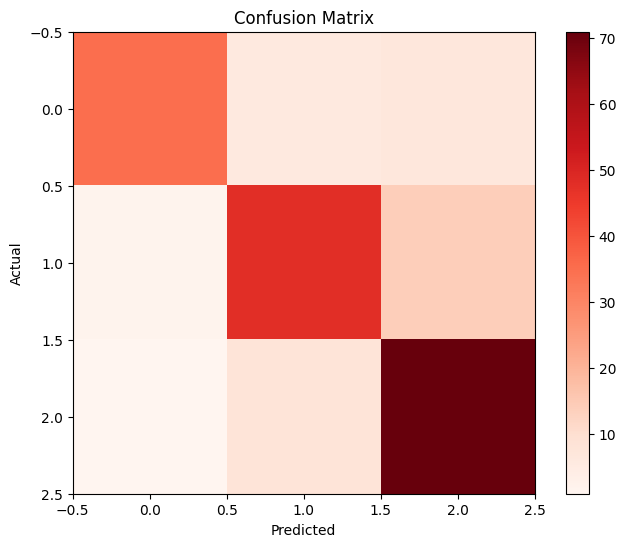

In [54]:
# Visualize the confusion matrix
# Create a figure and axis for the plot
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Reds)

# Add title and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Display the confusion matrix with appropriate colorbar
plt.colorbar()
plt.show()

In [30]:
# View Cassification Report
# Calculate and print the classification report
report = classification_report(test_labels,predicted_labels.argmax(axis=1),target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      Broken       0.95      0.73      0.82        48
      Defect       0.83      0.81      0.82        64
        Good       0.79      0.91      0.85        80

    accuracy                           0.83       192
   macro avg       0.85      0.82      0.83       192
weighted avg       0.84      0.83      0.83       192



In [79]:

def apply_weight_clustering(model, num_of_clusters, clustering_learning_rate):
    """
    Apply weight clustering to the given model.

    Parameters:
    - model (tf.keras.Model): The input model to be clustered.
    - num_of_clusters (int): The number of clusters to use for weight clustering.
    - clustering_learning_rate (float): The learning rate for fine-tuning the clustered model.

    Returns:
    - tf.keras.Model: The clustered model.
    """

    # Import required modules from TensorFlow Model Optimization
    cluster_weights = tfmot.clustering.keras.cluster_weights
    CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

    # Set clustering parameters
    clustering_params = {
        'number_of_clusters': num_of_clusters,
        'cluster_centroids_init': CentroidInitialization.LINEAR
    }

    # Cluster the whole model
    clustered_model = cluster_weights(model, **clustering_params)

    # Use a smaller learning rate for fine-tuning the clustered model
    opt = tf.keras.optimizers.Adam(learning_rate=clustering_learning_rate)

    # Compile the clustered model with specified metrics
    clustered_model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc_roc'),
            AUC(name='auc_pr', curve='PR')
        ]
    )

    # Display a summary of the clustered model
    clustered_model.summary()

    return clustered_model




In [ ]:
# Apply weight clustering for model
num_of_clusters=16
clustering_learning_rate=1e-5

clustered_model = apply_weight_clustering(model,num_of_clusters,clustering_learning_rate)

In [ ]:
# Fine-tune model
clustered_model.fit(
augmented_train_dataset,
  steps_per_epoch=steps_per_epoch*3,
  epochs=1,
  validation_data =validation_dataset,validation_steps=validation_steps*3)

In [48]:
# Compare models performances
baseline_model_metrics = model.evaluate(validation_dataset,steps=validation_steps*3)
clustered_model_metrics = clustered_model.evaluate(validation_dataset,steps=validation_steps*3)

72/72 [==============================] - 416s 6s/step - loss: 0.4416 - accuracy: 0.8515


In [49]:

baseline_metrics = {
    'Loss': baseline_model_metrics[0],
    'Accuracy': baseline_model_metrics[1],

}

clustered_metrics = {
    'Loss': clustered_model_metrics[0],
    'Accuracy': clustered_model_metrics[1],

}


print("Metrics for Baseline Model:")
for metric_name, metric_value in baseline_metrics.items():
    print(f"{metric_name}: {metric_value}")

print("\nMetrics for Clustered Model:")
for metric_name, metric_value in clustered_metrics.items():
    print(f"{metric_name}: {metric_value}")




Metrics for Baseline Model:
Loss: 0.45265692472457886
Accuracy: 0.8468044996261597

Metrics for Clustered Model:
Loss: 0.4415624141693115
Accuracy: 0.8515037298202515


In [ ]:
clustered_labels = make_predictions(clustered_model, test_dataset, num_test_samples)


In [50]:
# Calculate the confusion matrix
confusion = confusion_matrix(test_labels,clustered_labels.argmax(axis=1))

print("Confusion Matrix:")
print(confusion)




192/192 [==============================] - 657s 3s/step
Confusion Matrix:
[[35  6  7]
 [ 2 48 14]
 [ 1  8 71]]


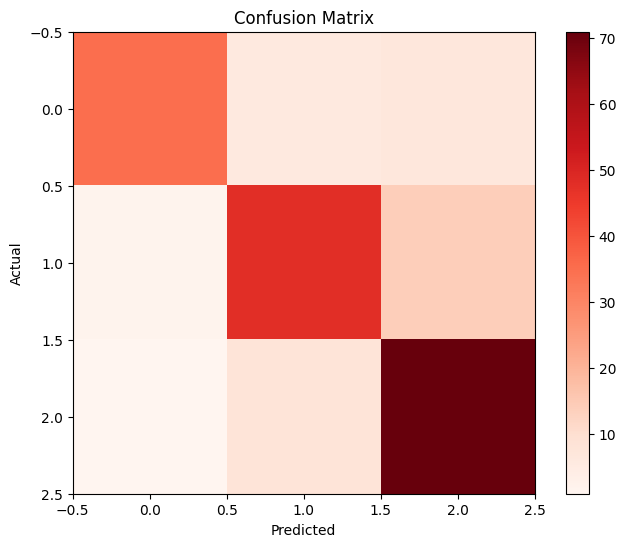

In [55]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Reds)

# Add title and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Display the confusion matrix with appropriate colorbar
plt.colorbar()
plt.show()

In [52]:
# Calculate and print the classification report
report = classification_report(test_labels, clustered_labels.argmax(axis=1),target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      Broken       0.92      0.73      0.81        48
      Defect       0.77      0.75      0.76        64
        Good       0.77      0.89      0.83        80

    accuracy                           0.80       192
   macro avg       0.82      0.79      0.80       192
weighted avg       0.81      0.80      0.80       192



In [ ]:
# Prepare model for serving by removing training-only variables.
model_for_serving = tfmot.clustering.keras.strip_clustering(clustered_model)

In [ ]:
model_for_serving .save('Model_for_Serving.h5')